In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import thermodynamics as td
from montecarlo import *
from energy import *

Some interesting ideas:

* Numerical method to find autocorrelation time? 
* See how the time taken increases for a 100*100 lattice. - time taken is 242 minutes or approximately 4 hours for a single temperature. Still this is too much. 
* Idea -*Can we, say, train a 'scale invariant machine learning model' , we train it on small lattices, and we can generate large lattice size* configurations easily from the trained decoder or something? This will make snapshot generation easier

Possible improvements:
* further improvements in space and time complexity in the following code?
* What kind of time requirements in saving the snapshots, optimal function to do so
* Improved estimators using clusters for estimating magnetisation etc. 

Other ideas:
* Can we create a gif/animation of the equilibriation process/ the markov chain? 

## Determination of autocorrelation time and equilibriation time

This is done for N=8

Let us do the following:
1. Take temperatures 1,2,3,4,5
2. For each temperature, perform the monte carlo for 1000 + 300 steps, 300 for equilibriation
3. Now, for each temperature, plot how the magnetisation changes in the monte carlo time
4. Verify that 300 indeed is a good number for equilibriation
5. Now, calculate the autocorrelation function for each temperature using the formula.
6. Plot the ACF for different temperatures
7. Now extract the autocorrelation time for each temperature

Once all of this is done, write this down into one single function/set of functions and repeat for N=[10,20,30,40,50]

See the following link: https://dfm.io/posts/autocorr/

### Important
Check if the code below is indeed correct. Why aren't we seeing critical slowing down? Check the following links:

https://physics.stackexchange.com/questions/626649/decorrelation-times-for-a-2d-ising-model-over-a-range-of-temperatures
https://physics.stackexchange.com/questions/445197/periodic-autocorrelation-function-for-ising-model?rq=1

See if your results match these. Keep doing it for 8*8 lattices till you are convinced

0. An important issue - negative or less than 1 or 2, or fractional AC times???
1. Key issue is that - we aren't seeing critical slowing in our plots. Ideally, the autocorrelation time must diverge near the critical point (peak in the case of finite lattices). But in our case instead of peaking it monotonically increased for increasing temperature. Check if this happens with the metropolis algorithm [resolved]

2. For better plots, use parallel chains at same temperature, calculate autocorrelation times for each, then average

3. There are two ways of calculating the AC time. One is the cumsum method you have used, the other is to fit a exponentially decaying curve of the form $e^{-t/\tau}$ to extract $\tau$

In [2]:
# Autocorrelation function #

def acf(data):
    ''' explain the logic of this code '''
    ''' Optimize this function '''
    x = np.array(data) 

    # Mean
    mean = np.mean(data)

    # Variance
    var = np.var(data)

    # Normalized data
    ndata = data - mean

    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)

    return acorr

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# For the following two functions, we use the link above.

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_time(AC_f, c=5.0):
    taus = 2.0 * np.cumsum(AC_f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [ ]:
# Temperature array for actual simulation #

Temp = np.array(range(1,51))/10 # temperatures in steps of 0.1
Temp1 = np.array(range(200,300))/100 # more dense sampling of temperature around critical value
temp_AC = np.unique(np.append(Temp,Temp1)) # final temperature array

In [3]:
# Temperatures for running diagnostics and seeing correctness #

temp_AC = np.array([0.1,0.5,1,1.5,1.7,1.9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.2,3.4,3.8,4,4.4,4.8,5])


iterations = 100000
t_eq = 300
T = iterations + t_eq
sizes = [5] # 8,16,32,64] # 64 takes too much time
# We use 5 for metropolis

mag = [] # monte carlo evolution of magnetisation for different temperatures
Mag = []
energy_MC = [] # monte carlo evolution of energy for different temperatures
ACF = []
tau = []
Tau = []
temp_mag = []
temp_ACF = []

t=0

# Please try to understand the time scales relevant here in this code
# Also, how about a cluster size plot for this??
# How to speed up this calculation?

for size in sizes:
    for i in temp_AC:
        beta = 1/i
        lattice = 2*np.random.randint(0,2,(size,size))-1
        temp_mag = []
        temp_energy = []
        t = 0
        while t<T:
            lattice,clusters = Wolff(lattice,beta) #mcCycle(lattice,N=size,Temp=beta**(-1)) #
            temp_mag.append(td.magnetisation(lattice))
            #temp_energy.append(hamilton(lattice, J=1))
            t += 1
        #energy_MC.append(temp_energy)
        #mag.append(temp_mag)
        temp_ACF = autocorr_func_1d(temp_mag)
        #ACF.append(temp_ACF)
        tau.append(autocorr_time(temp_ACF))
    Tau.append(tau)
    tau = []
    Mag.append(mag)
    mag = []
    print("There, there, this won't take much time.")
    


There, there, this won't take much time.


In [ ]:
np.savetxt("AutoCorr_times.csv",Tau)
np.savetxt("Mags_MC_simulation.csv",Mag)

# Some Results of the above code

1. The plot below was obtained for a $5 \times 5$ lattice of spins with the algorithm for random update being the Metropolis algorithm. One can clearly see the critical slowing down problem in this case, with the autocorrelation time increasing abruptly near the finite size pseudo critical point, and then reducing exponentially. The monte carlo chain at each temperature was 100000 instances long.

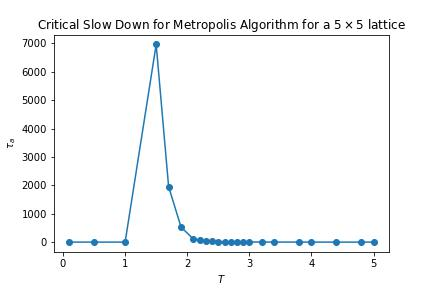

In [14]:
from IPython import display
display.Image("Metropolis_CSD.jpg")

Question - what is the reason behind critical slowing down in metropolis algorithm?

*Write this down*

1. There is an issue for temperatures $T<T_c$ - the magnetisation changes almost with every Wolff step. How to remedy this? I believe this is the same issue which causes the discrepancy in the magnetisation values for lower temperatures. It may happen that for some arbitrarily chosen autocorrelation time, at very low temperatures it might randomly choose spin up and spin down GS configs and if there is an imbalance on either side the number will be off from $\pm 1$ - *This is essentially a question of choosing a good autocorrelation time*

2. Another issue - negative autocorrelation time for some cases (below critical temperatures usually). The worse problem is that the autocorrelation time is FRACTIONAL below critical temperatures with this method of calculation. PERHAPS this maybe fixed by using energy instead of magnetisation. 

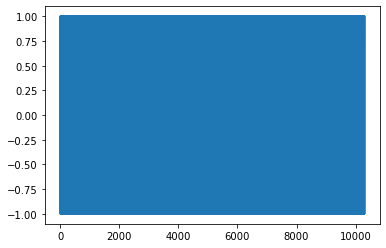

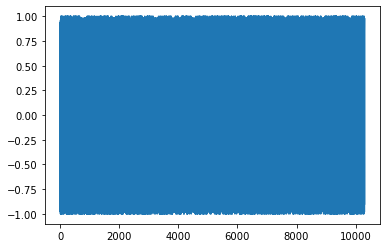

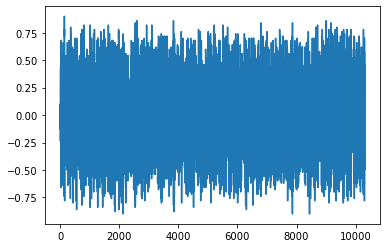

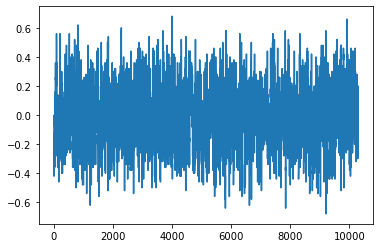

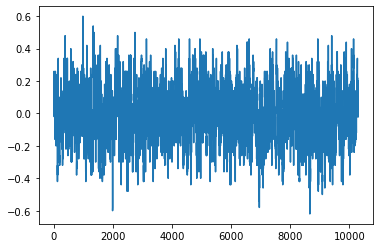

In [20]:
# Plotting monte carlo evolution of magnetisations for each temperature
for i in temp_AC:
    plt.plot(mag[i-1])
    plt.show()

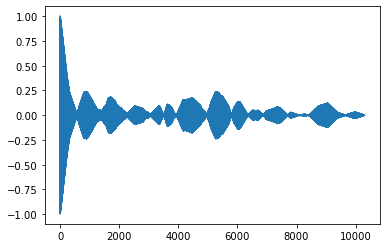

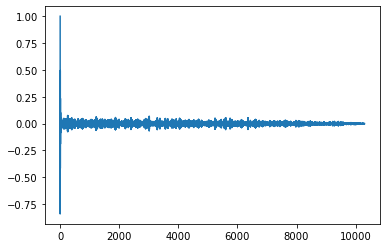

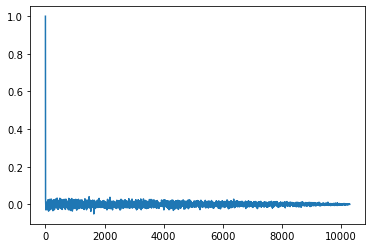

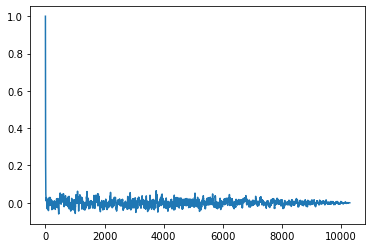

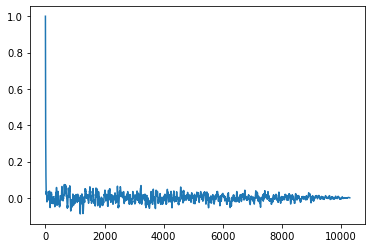

In [21]:
# Plotting ACF of magnetisations for each temperature
for i in temp_AC:
    plt.plot(ACF[i-1])
    plt.show()

In [ ]:
autocorr_time_v_temp = []
for i in temp_AC:
    autocorr_time_v_temp.append(autocorr_time(ACF[i-1]))

## Fixing the large cluster size issue

In [35]:
# check for duplicates

Observations/Issues:
* How are the average and largest cluster size larger than the system size itself?? (at low temperatures..)
* algorithm equilibriates by 250th step for a 100*100 lattice. This is a good enough cutoff time for smaller lattices also.
* *Question - Does the equilibriation time change with temperature?* - if indeed it does, then does the above cutoff value still hold?
* Is there any need for an Autocorrelation time at all? *How to find it??*
* Can we find autocorrelation time from time series measurements, say from the magnetisation time series?

The essential goal is to use the wolff step rather than the metropolis step in the code. This will speed up the simulations by a huge amount. If we can find a way to store the clusters or do something with the clusters, then that will help us too. 

Other tasks:
* Do a small literature review on the current progress on applying ML to ising model and phase transitions.
* Fix the low temperature issue for metropolis algo., see if Wolff Algo. faces the same issue
* More thermodynamic and statistical functions, see the assignment pdf
* Finite size scaling and calculating critical exponents.

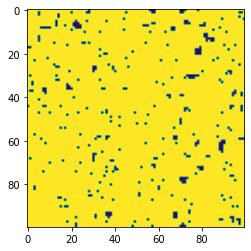

In [7]:
plt.imshow(lattice)